## Lab 6-1: Softmax Classification

### Imports

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# For reproducibility
torch.manual_seed(1)

### SoftMax

확률로 만들어주는 함수

In [3]:
z = torch.FloatTensor([1, 2, 3])

#### pytorch has softmax function

In [4]:
hypothesis = F.softmax(z,dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


확률이기 때문에 총합이 무조건 1이다

In [5]:
hypothesis.sum() #총합은 1

tensor(1.)

### Cross Entropy Loss (Low-level)

Multi-Class 분류에서 cross entropy loss를 loss function으로 사용한다 

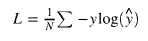

In [6]:
from IPython.display import Image

Image('crossentropyloss.PNG')

y 는 실제값, y^은 예측값

#### 5개의 classes와 3개의 sample을 가진 예시

In [7]:
z = torch.rand(3,5, requires_grad= True)#3행 5열의 random 2차원 행렬 생성
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward>)


In [8]:
y = torch.randint(5,(3,)).long() #class 정답을 y라고 설정
print(y)

tensor([0, 2, 1])


답이 0,2,1 이므로 index가 각각 0,2,1인 자리에 1을 부여하고(source) 나머지는 dummy 처리

- dim = 0 아래방향(행)

- dim = 1 가로방향(열)

In [9]:
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1),1) # scatter_(dim:차원축, index, source)

#unsqueeze함수는 squeeze함수의 반대로 1인 차원을 생성하는 함수이다. 
#그래서 어느 차원에 1인 차원을 생성할 지 꼭 지정해주어야한다

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [10]:
cost = (y_one_hot* -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


### Cross-entropy Loss with torch.nn.functional

Pytorch has F.log_softmax() function

In [17]:
#low level
torch.log(F.softmax(z,dim=1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward>)

In [18]:
#high level
F.log_softmax(z,dim=1)   # 바로 log softmax가 되는 함수

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward>)

PyTorch also has F.nll_loss() function that computes the negative loss likelihood.



In [19]:
#low level

(y_one_hot * -torch.log(F.softmax(z,dim=1))).sum(dim=1).mean()  #다 더해주고 평균내기

tensor(1.4689, grad_fn=<MeanBackward0>)

In [20]:
#high level
#NLL = negative log likelihood

F.nll_loss(F.log_softmax(z,dim=1),y)

tensor(1.4689, grad_fn=<NllLossBackward>)

PyTorch also has F.cross_entropy that combines F.log_softmax() and F.nll_loss().

마지막으로 단순화해주는 함수!!

(y_one_hot * -torch.log(F.softmax(z,dim=1))).sum(dim=1).mean()==F.cross_entropy(z,y)

In [21]:
F.cross_entropy(z,y)  #(y_one_hot * -torch.log(F.softmax(z,dim=1))).sum(dim=1).mean() 

tensor(1.4689, grad_fn=<NllLossBackward>)

### Training with Low-level Cross Entropy Loss

In [23]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]

x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

print(x_train)

tensor([[1., 2., 1., 1.],
        [2., 1., 3., 2.],
        [3., 1., 3., 4.],
        [4., 1., 5., 5.],
        [1., 7., 5., 5.],
        [1., 2., 5., 6.],
        [1., 6., 6., 6.],
        [1., 7., 7., 7.]])


In [24]:
#모델 초기화하기
W = torch.zeros((4,3), requires_grad = True)
b = torch.zeros(1, requires_grad= True)

#opimizer 설정
optimizer = optim.SGD([W,b], lr = 0.1)

nb_epochs = 1000

for epoch in range(nb_epochs+1):
    
    #Cost 계산 (1)
    hypothesis = F.softmax(x_train.matmul(W)+b, dim =1)
    y_one_hot = torch.zeros_like(hypothesis)
    y_one_hot.scatter_(1, y_train.unsqueeze(1),1)
    cost = (y_one_hot * -torch.log(F.softmax(hypothesis, dim=1))).sum(dim=1).mean()
    
    #cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    #100번마다 로그 출력하기
    if epoch % 100 ==0:
        print('Epoch {:4d}/{} Cost : {:.6f}'.format(
        epoch, nb_epochs, cost.item()))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/autograd/__init__.py:149: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630806732/work/c10/cuda/CUDAFunctions.cpp:115.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Epoch    0/1000 Cost : 1.098612
Epoch  100/1000 Cost : 0.901535
Epoch  200/1000 Cost : 0.839114
Epoch  300/1000 Cost : 0.807826
Epoch  400/1000 Cost : 0.788472
Epoch  500/1000 Cost : 0.774822
Epoch  600/1000 Cost : 0.764449
Epoch  700/1000 Cost : 0.756191
Epoch  800/1000 Cost : 0.749398
Epoch  900/1000 Cost : 0.743671
Epoch 1000/1000 Cost : 0.738749


### Training with F.cross_entropy


In [28]:
#모델 초기화하기
W = torch.zeros((4,3), requires_grad = True)
b = torch.zeros(1, requires_grad= True)

#optimizer 설정
optimizer = optim.SGD([W,b], lr =0.1)

nb_epochs = 1000

for epoch in range(nb_epochs +1):
    
    #Cost 계산하기
    z = x_train.matmul(W) +b # hypothesis
    cost = F.cross_entropy(z,y_train)
    
    #cost 로 H(x)개선하기
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    #100 번마다 로그 출력하기
    if epoch %100 ==0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568256
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


### High-level Implementation with nn.Module

In [33]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3이어야함 (0,1,2)

    def forward(self, x):
        return self.linear(x)

In [34]:
model = SoftmaxClassifierModel()

In [38]:
#optimizer 설정

optimizer = optim.SGD(model.parameters(),lr= 0.1)

nb_epochs = 1000

for epoch in range(nb_epochs+1):
    
    #H(x) 계산
    prediction = model(x_train)
    
    #cost 계산
    cost = F.cross_entropy(prediction, y_train)
    
    #cost 로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    #20번마다 로그 출력
    if epoch %2 ==0:
        print('Epoch {:4d}/{} Cost : {:6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0/1000 Cost : 1.046181
Epoch    2/1000 Cost : 0.929780
Epoch    4/1000 Cost : 0.891565
Epoch    6/1000 Cost : 0.866827
Epoch    8/1000 Cost : 0.859701
Epoch   10/1000 Cost : 0.881199
Epoch   12/1000 Cost : 0.920918
Epoch   14/1000 Cost : 0.935701
Epoch   16/1000 Cost : 0.923506
Epoch   18/1000 Cost : 0.904911
Epoch   20/1000 Cost : 0.887267
Epoch   22/1000 Cost : 0.871683
Epoch   24/1000 Cost : 0.858027
Epoch   26/1000 Cost : 0.845991
Epoch   28/1000 Cost : 0.835288
Epoch   30/1000 Cost : 0.825683
Epoch   32/1000 Cost : 0.816984
Epoch   34/1000 Cost : 0.809045
Epoch   36/1000 Cost : 0.801748
Epoch   38/1000 Cost : 0.794997
Epoch   40/1000 Cost : 0.788718
Epoch   42/1000 Cost : 0.782850
Epoch   44/1000 Cost : 0.777342
Epoch   46/1000 Cost : 0.772152
Epoch   48/1000 Cost : 0.767245
Epoch   50/1000 Cost : 0.762590
Epoch   52/1000 Cost : 0.758164
Epoch   54/1000 Cost : 0.753942
Epoch   56/1000 Cost : 0.749907
Epoch   58/1000 Cost : 0.746041
Epoch   60/1000 Cost : 0.742330
Epoch   

Epoch  896/1000 Cost : 0.270316
Epoch  898/1000 Cost : 0.269522
Epoch  900/1000 Cost : 0.268733
Epoch  902/1000 Cost : 0.267950
Epoch  904/1000 Cost : 0.267174
Epoch  906/1000 Cost : 0.266404
Epoch  908/1000 Cost : 0.265640
Epoch  910/1000 Cost : 0.264883
Epoch  912/1000 Cost : 0.264134
Epoch  914/1000 Cost : 0.263392
Epoch  916/1000 Cost : 0.262658
Epoch  918/1000 Cost : 0.261932
Epoch  920/1000 Cost : 0.261214
Epoch  922/1000 Cost : 0.260505
Epoch  924/1000 Cost : 0.259805
Epoch  926/1000 Cost : 0.259115
Epoch  928/1000 Cost : 0.258434
Epoch  930/1000 Cost : 0.257763
Epoch  932/1000 Cost : 0.257103
Epoch  934/1000 Cost : 0.256453
Epoch  936/1000 Cost : 0.255814
Epoch  938/1000 Cost : 0.255187
Epoch  940/1000 Cost : 0.254571
Epoch  942/1000 Cost : 0.253966
Epoch  944/1000 Cost : 0.253374
Epoch  946/1000 Cost : 0.252794
Epoch  948/1000 Cost : 0.252226
Epoch  950/1000 Cost : 0.251671
Epoch  952/1000 Cost : 0.251129
Epoch  954/1000 Cost : 0.250600
Epoch  956/1000 Cost : 0.250083
Epoch  9